<a href="https://colab.research.google.com/github/Inder-Dhillon/Toronto-Accidents-As-A-Network/blob/df-filtering/Project_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo apt install libspatialindex-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libspatialindex-dev is already the newest version (1.8.5-5).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [2]:
!wget https://github.com/Inder-Dhillon/Toronto-Accidents-As-A-Network/blob/df-filtering/accident.py?raw=true
!mv accident.py\?raw\=true accident.py

--2020-12-08 05:03:16--  https://github.com/Inder-Dhillon/Toronto-Accidents-As-A-Network/blob/df-filtering/accident.py?raw=true
Resolving github.com (github.com)... 52.192.72.89
Connecting to github.com (github.com)|52.192.72.89|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Inder-Dhillon/Toronto-Accidents-As-A-Network/raw/df-filtering/accident.py [following]
--2020-12-08 05:03:17--  https://github.com/Inder-Dhillon/Toronto-Accidents-As-A-Network/raw/df-filtering/accident.py
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Inder-Dhillon/Toronto-Accidents-As-A-Network/df-filtering/accident.py [following]
--2020-12-08 05:03:17--  https://raw.githubusercontent.com/Inder-Dhillon/Toronto-Accidents-As-A-Network/df-filtering/accident.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ..

In [3]:
pip install osmnx

In [4]:
import osmnx as ox
import networkx as nx
from networkx.algorithms.community.centrality import girvan_newman
import pandas as pd
import json
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from accident import ACCIDENT

In [5]:
G = ox.graph_from_place('Toronto, Ontario, Canada', network_type='drive')

In [ ]:
#G = ox.consolidate_intersections(ox.project_graph(G), tolerance=30, rebuild_graph=True)

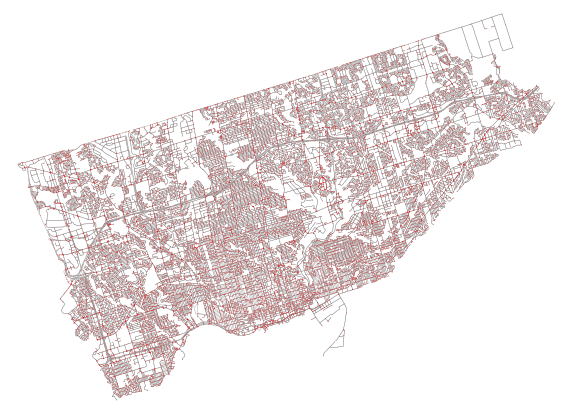

(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

In [ ]:
ox.plot_graph(G, bgcolor='white', node_size=0.3, node_color="red", edge_linewidth=0.4, edge_alpha=1, dpi=300, figsize=(10,10))

In [ ]:
print(nx.info(G))

Name: 
Type: MultiDiGraph
Number of nodes: 27460
Number of edges: 73230
Average in degree:   2.6668
Average out degree:   2.6668


In [ ]:
edges =  list(G.edges.data())
edges[52][2]

{'geometry': <shapely.geometry.linestring.LineString at 0x7fd3dfc08518>,
 'highway': 'motorway',
 'lanes': '5',
 'length': 334.943,
 'maxspeed': '100',
 'name': 'Highway 401 Collectors',
 'oneway': True,
 'osmid': 4071678,
 'ref': '401'}

In [ ]:
nodes =  list(G.nodes.data())
nodes[1]

(1497798, {'osmid': 1497798, 'x': -79.3355379, 'y': 43.7580721})

## KSI Dataset:

In [6]:
ksi_df = gpd.read_file("https://opendata.arcgis.com/datasets/cc17cc27ee5a4989b78d9a3810c6c007_0.geojson")

In [7]:
ksi_df.head()

Index_  ACCNUM  ...  ObjectId                    geometry
0  3389067  893184  ...         1  POINT (-79.31880 43.69960)
1  3389068  893184  ...         2  POINT (-79.31880 43.69960)
2  3389069  893184  ...         3  POINT (-79.31880 43.69960)
3  3389070  893184  ...         4  POINT (-79.31880 43.69960)
4  3389071  893184  ...         5  POINT (-79.31880 43.69960)

[5 rows x 55 columns]

In [8]:
def assign_injury_index(injury:str):
  if injury == "Minimal":
    return 0.4
  elif injury == "Minor":
    return 0.6
  elif injury == "Major":
    return 0.8
  elif injury == "Fatal":
    return 1.0
  else:
    return 0.2

In [10]:
ksi_df["INJ_INDEX"] = ksi_df["INJURY"].apply(lambda x: assign_injury_index(x))

In [11]:
index_df = ksi_df[["ACCNUM", "INJ_INDEX"]].groupby(by="ACCNUM").sum()

Combining Date and Hour to have one single column:

In [ ]:
# ksi_df["DATE"] = pd.to_datetime(ksi_df['DATE']).dt.floor("D") + pd.to_timedelta(ksi_df["HOUR"], unit="hour")

Add datapoints to keep here:

In [12]:
cols_to_keep = ["LATITUDE", "LONGITUDE", "ACCNUM", "YEAR","TIME", "VISIBILITY", "LIGHT",	"RDSFCOND"]
ksi_df = ksi_df[cols_to_keep]

Counting fatalities using duplicate rows:

In [13]:
fatalities = ksi_df["ACCNUM"].value_counts()
ksi_df["FATALITIES"] = ksi_df["ACCNUM"].apply(lambda x : fatalities[x])

In [14]:
ksi_df = ksi_df.drop_duplicates()
ksi_df.reset_index(drop=True, inplace=True)

In [15]:
ksi_df["G_NODE"]= ox.get_nearest_nodes(G, ksi_df["LONGITUDE"], ksi_df["LATITUDE"], method="balltree")
ksi_df.drop(["LATITUDE", "LONGITUDE"], axis=1, inplace=True)

In [16]:
ksi_df = ksi_df.merge(index_df, on="ACCNUM")

In [17]:
ksi_df = ksi_df.infer_objects()
ksi_df

ACCNUM  YEAR  TIME  ... FATALITIES     G_NODE INJ_INDEX
0         893184  2006   236  ...          8   33771082       4.2
1         909646  2006   315  ...          5  158754118       2.4
2         884090  2006   705  ...          2   21631723       1.0
3         885782  2006  1940  ...          2   26007459       1.0
4         882079  2006  2210  ...          2  259750208       1.0
...          ...   ...   ...  ...        ...        ...       ...
5685  9002468442  2019   657  ...          2   86186677       1.0
5686  9002471073  2019  1415  ...          3  287946845       1.8
5687  9002481518  2019   850  ...          2    1498033       1.0
5688  9002496688  2019  2324  ...          2  392516842       1.0
5689  9002500260  2019  1514  ...          3   29603262       1.2

[5690 rows x 9 columns]

Creating column of accident objects:

In [18]:
ksi_df["ACCIDENT"] = ksi_df.apply(lambda x: ACCIDENT(x["ACCNUM"],x["YEAR"], x["TIME"], x["VISIBILITY"], x["LIGHT"], x["RDSFCOND"], x["FATALITIES"], x["INJ_INDEX"]), axis=1)

In [19]:
ksi_df

ACCNUM  ...                                           ACCIDENT
0         893184  ...  ACCIDENT(acc_id='893184', year=2006, time='236...
1         909646  ...  ACCIDENT(acc_id='909646', year=2006, time='315...
2         884090  ...  ACCIDENT(acc_id='884090', year=2006, time='705...
3         885782  ...  ACCIDENT(acc_id='885782', year=2006, time='194...
4         882079  ...  ACCIDENT(acc_id='882079', year=2006, time='221...
...          ...  ...                                                ...
5685  9002468442  ...  ACCIDENT(acc_id='9002468442', year=2019, time=...
5686  9002471073  ...  ACCIDENT(acc_id='9002471073', year=2019, time=...
5687  9002481518  ...  ACCIDENT(acc_id='9002481518', year=2019, time=...
5688  9002496688  ...  ACCIDENT(acc_id='9002496688', year=2019, time=...
5689  9002500260  ...  ACCIDENT(acc_id='9002500260', year=2019, time=...

[5690 rows x 10 columns]

## Dataset Filtering

VISIBILITY:

In [20]:
notclear_df = ksi_df.loc[~ksi_df.VISIBILITY.isin(["Clear"])]

In [21]:
clear_df = ksi_df.loc[ksi_df.VISIBILITY.isin(["Clear"])]

RDSFCOND:

In [22]:
dry_road_df = ksi_df.loc[ksi_df.RDSFCOND.isin(["Dry"])]

In [23]:
wet_road_df = ksi_df.loc[ksi_df.RDSFCOND.isin(["Wet"])]

In [24]:
other_road_df = ksi_df.loc[~ksi_df.RDSFCOND.isin(["Dry", "Wet"])]

Time of Day:

In [25]:
ksi_df.TIME = pd.to_numeric(ksi_df.TIME, errors='coerce')
rush_hour_df = ksi_df.loc[(ksi_df.TIME.between(630,930, inclusive=True)) | (ksi_df.TIME.between(1500,1900, inclusive=True))]

In [26]:
day_time_df = ksi_df.loc[ksi_df.TIME.between(701,1900, inclusive=True)]

In [27]:
night_time_df = ksi_df.loc[ksi_df.TIME.between(1901,700, inclusive=True)]

Yearly

In [28]:
df_2006_10 = ksi_df.loc[ksi_df.YEAR.isin(["2006", "2007", "2008", "2009", "2010"])]

In [29]:
df_2011_15 = ksi_df.loc[ksi_df.YEAR.isin(["2011", "2012", "2013", "2014", "2015"])]

In [30]:
df_2016_19 = ksi_df.loc[ksi_df.YEAR.isin(["2016", "2017", "2018", "2019"])]

## Processing a given Dataset

Set the Dataset to work on:

In [31]:
given_df = df_2006_10

Collapsing dataset to get list of accidents for each node:

In [32]:
given_df = given_df.groupby('G_NODE')['ACCIDENT'].apply(list).reset_index(name='ACCIDENTS')

In [33]:
given_df

G_NODE                                          ACCIDENTS
0        1498018  [ACCIDENT(acc_id='1126375', year=2009, time='2...
1        1498033  [ACCIDENT(acc_id='1152152', year=2010, time='2...
2        3458697  [ACCIDENT(acc_id='1154990', year=2010, time='2...
3        3458699  [ACCIDENT(acc_id='1128816', year=2009, time='1...
4        3458858  [ACCIDENT(acc_id='923894', year=2006, time='22...
...          ...                                                ...
1778  7606751368  [ACCIDENT(acc_id='940240', year=2006, time='18...
1779  7606751371  [ACCIDENT(acc_id='1126056', year=2009, time='2...
1780  7620170933  [ACCIDENT(acc_id='1025433', year=2008, time='1...
1781  7870612852  [ACCIDENT(acc_id='922700', year=2006, time='14...
1782  8151877191  [ACCIDENT(acc_id='1032504', year=2008, time='1...

[1783 rows x 2 columns]

Converting dataset to dict to set node attributes:

In [34]:
attr = given_df.set_index('G_NODE')['ACCIDENTS'].to_dict()

In [35]:
nx.set_node_attributes(G, [], "accident_list")
nx.set_node_attributes(G, attr, "accident_list")

Example Nodes:

In [31]:
G.nodes[1497983]

{'accident_list': [], 'osmid': 1497983, 'x': -79.3472824, 'y': 43.7521302}

In [36]:
G.nodes[158754118]

{'accident_list': [ACCIDENT(acc_id='909646', year=2006, time='315', visibility='Snow', light='Dark, artificial', road_conditions='Slush', fatalities=5, inj_index=2.4000000000000004)],
 'osmid': 158754118,
 'x': -79.3162254,
 'y': 43.6849494}

In [37]:
#check if node has an accident list if so
#go through each edge on the node if the edge is connecting to a node that also has an injury index then
#add its length to the cumulative length
#W base = no of accidents * avg inj_index for each accident on the node
#distribute weight to edges as follows, total length/edge length * Wbase

def getEdgeWeights(df):
  #dictionary of edge tuples to weight
  weights = {}

  sumGraphWeights = 0 #used to get the sum of all injury indexes in the 
  sumGraphNodes = 0
  #loop through each node
  for node in df['G_NODE']:
    #if G.nodes[node]['accident_list'] !=[]:
    totalLen = 0     
    totalWeight = 0    
    sumGraphNodes += 1
    for edge in nx.edges(G, node):
      totalLen += G.get_edge_data(edge[0], edge[1])[0]['length']
    for x in G.nodes[node]['accident_list']:
      totalWeight += x.inj_index
      sumGraphWeights += x.inj_index
    baseWeight = totalWeight/len(G.nodes[node]['accident_list'])
    for edge in nx.edges(G, node):
      weights[(edge[0], edge[1], 0)] = (totalLen/G.get_edge_data(edge[0], edge[1])[0]['length']) * baseWeight
  
  avgWeight = sumGraphWeights/sumGraphNodes
  
  for node in G.nodes:
    # if G.nodes[node]['accident_list'] == []:
    if node not in list(df['G_NODE']):
      totalLen = 0
      totalWeight = 0
      for edge in nx.edges(G, node):
        totalLen += G.get_edge_data(edge[0], edge[1])[0]['length']
      for edge in nx.edges(G, node):
        weights[(edge[0], edge[1], 0)] = (totalLen/G.get_edge_data(edge[0], edge[1])[0]['length']) *avgWeight

  return weights


In [38]:
weights = getEdgeWeights(given_df)
nx.set_edge_attributes(G, 0, 'w')
nx.set_edge_attributes(G, weights, 'w')
# nx.get_edge_attributes(G, 'w')

In [39]:
edges =  list(G.edges.data())
edges[1245]

(21421595,
 1339099026,
 {'highway': 'motorway_link',
  'lanes': '2',
  'length': 56.923,
  'oneway': True,
  'osmid': 4043991,
  'w': 7.6971464369284})

## PageRank

In [40]:
def pagerank_top_50(G):
  pr = nx.pagerank_scipy(G, weight='w')
  pr = pd.DataFrame.from_dict(pr, orient='index').sort_values(by=0, ascending=False).rename(columns={0:"PageRank Score"})
  return pr.iloc[:50]

In [41]:
def pagerank_from_df(G, df, n):
    pr = nx.pagerank_scipy(G, weight='w')
    obj_sorted = {k: v for k, v in sorted(pr.items(), key=lambda item: item[1], reverse=True) if k in list(df['G_NODE'])}
    return {k: obj_sorted[k] for k in list(obj_sorted.keys())[:n]}
  

def pretty_print(obj):
    df = pd.DataFrame.from_dict(obj, orient='index', columns=['PageRank Score']).rename_axis('Node')
    print(df)

In [ ]:
top_50 = pagerank_top_50(G)
top_50

In [43]:
ksi_top_50 = pagerank_from_df(G, ksi_df, 50)
given_df_top_50 = pagerank_from_df(G, given_df, 50)
df_2011_15_top_50 = pagerank_from_df(G, df_2011_15, 50)
df_2016_19_top_50 = pagerank_from_df(G, df_2016_19, 50)

In [49]:
len(set(df_2011_15_top_50.keys()) - set(given_df_top_50.keys()))

36

Printing Top Page Rank nodes

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


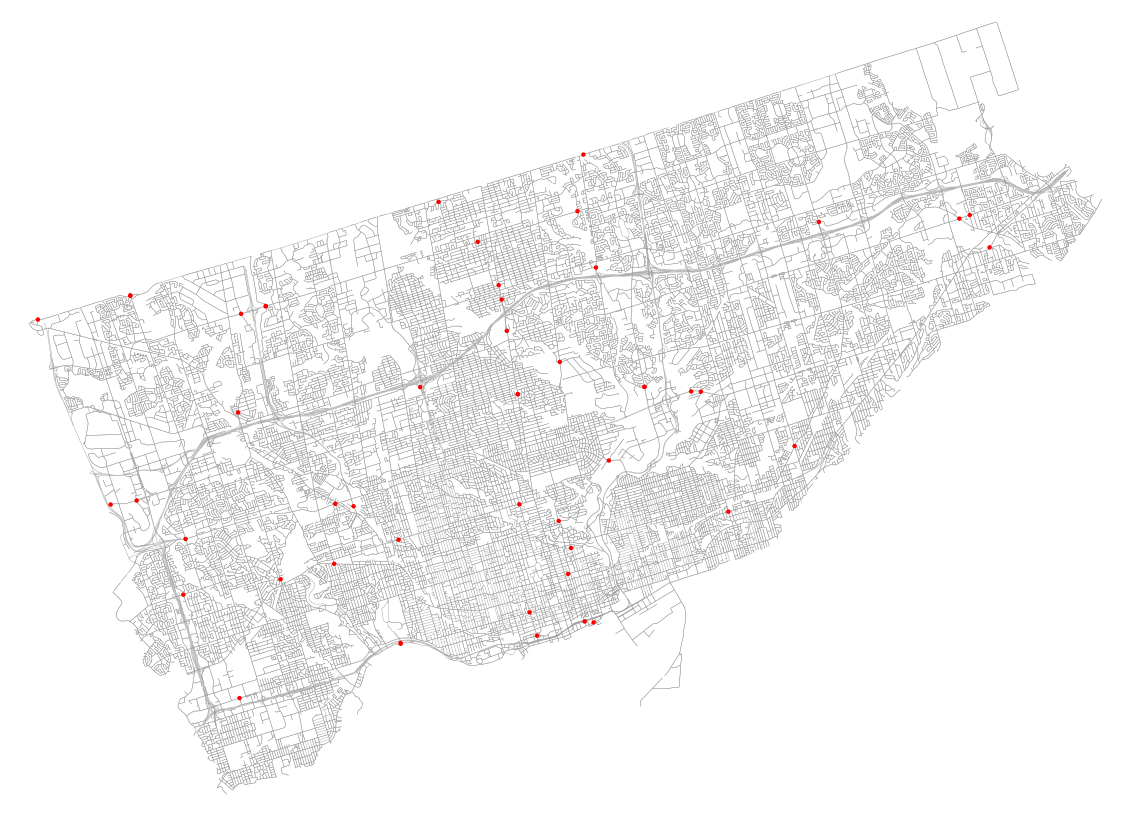

(<Figure size 1440x1440 with 1 Axes>, <AxesSubplot:>)

In [112]:
ec = ['r' if node in given_df_top_50 else (0,0,0,0) for node in G.nodes]
ox.plot_graph(G, bgcolor='white', node_size=20, node_color=ec, edge_linewidth=0.4, edge_alpha=1, dpi=300, figsize=(20,20))

## Routing

In [45]:
# add speed on all edges missing data
G = ox.add_edge_speeds(G)
# calculate travel time (seconds) for all edges
G = ox.add_edge_travel_times(G)

In [67]:
def print_route_time_distance(route):
  route_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route, 'length')))/1000
  route_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route, 'travel_time')))/60
  route_weight = int(sum(ox.utils_graph.get_route_edge_attributes(G, route, 'w')))
  print('Route is', format(route_length, '.2f'), 'kms and takes', format(route_time, '.2f'), 'minutes. This route has a total injury index of: ', route_weight)


Get the safest route using Dijkstra's algorithm

In [64]:
def get_route_by_risk(origin, destination):
  return nx.shortest_path(G, source=origin, target = destination, weight = 'w', method='dijkstra')

def get_route_by_length(origin, destination):
  return nx.shortest_path(G, source=origin, target = destination, weight = 'length', method='dijkstra')

def get_route_by_time(origin, destination):
  return nx.shortest_path(G, source=origin, target = destination, weight = 'travel_time', method='dijkstra')


Plotting the route

In [48]:
def plot_route(route_list, color):
  ox.plot_graph_route(G, bgcolor='white', node_size=1.0, node_color='gray', edge_color='gray',route=route_list, route_color = color, dpi=300, figsize=(20,20))

In [68]:
orig = list(G)[8963]
dest = list(G)[1]
route_time = get_route_by_time(orig, dest)
route_distance = get_route_by_length(orig, dest)
route_risk = get_route_by_risk(orig, dest)

In [69]:
#Printing route's time and distance
print("Quickest route")
print_route_time_distance(route_time)
print("Shortest route")
print_route_time_distance(route_distance)
print("Least accident prone route")
print_route_time_distance(route_risk)

Quickest route
Route is 22.88 kms and takes 19.37 minutes. This route has a total injury index of:  518
Shortest route
Route is 20.21 kms and takes 25.23 minutes. This route has a total injury index of:  646
Least accident prone route
Route is 30.93 kms and takes 24.63 minutes. This route has a total injury index of:  188


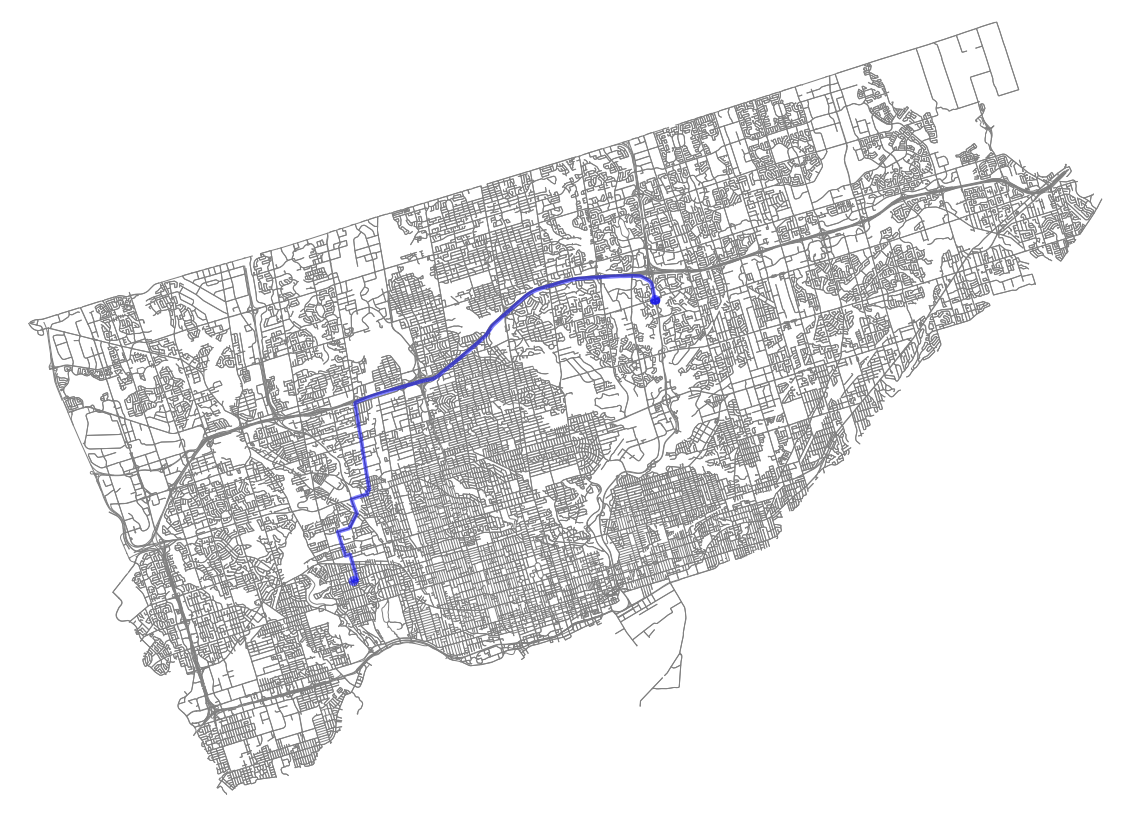

In [60]:
plot_route(route_time, 'b')

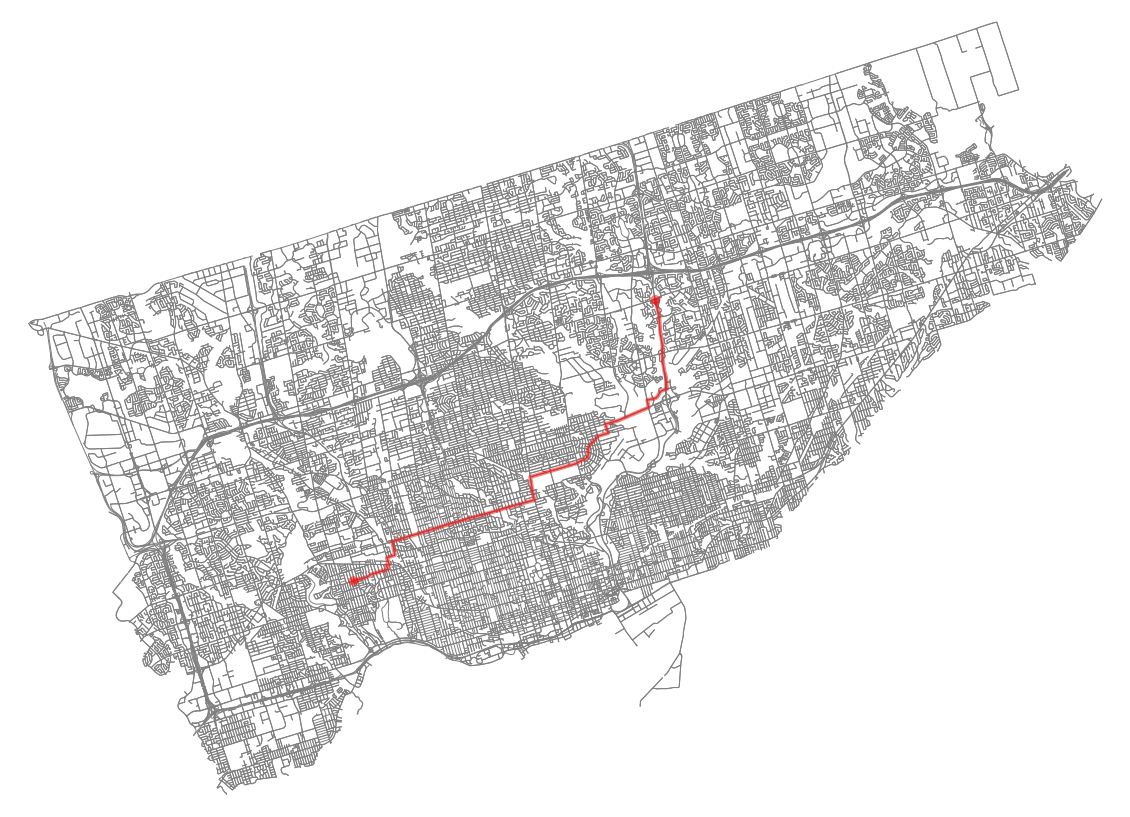

In [61]:
plot_route(route_distance, 'r')

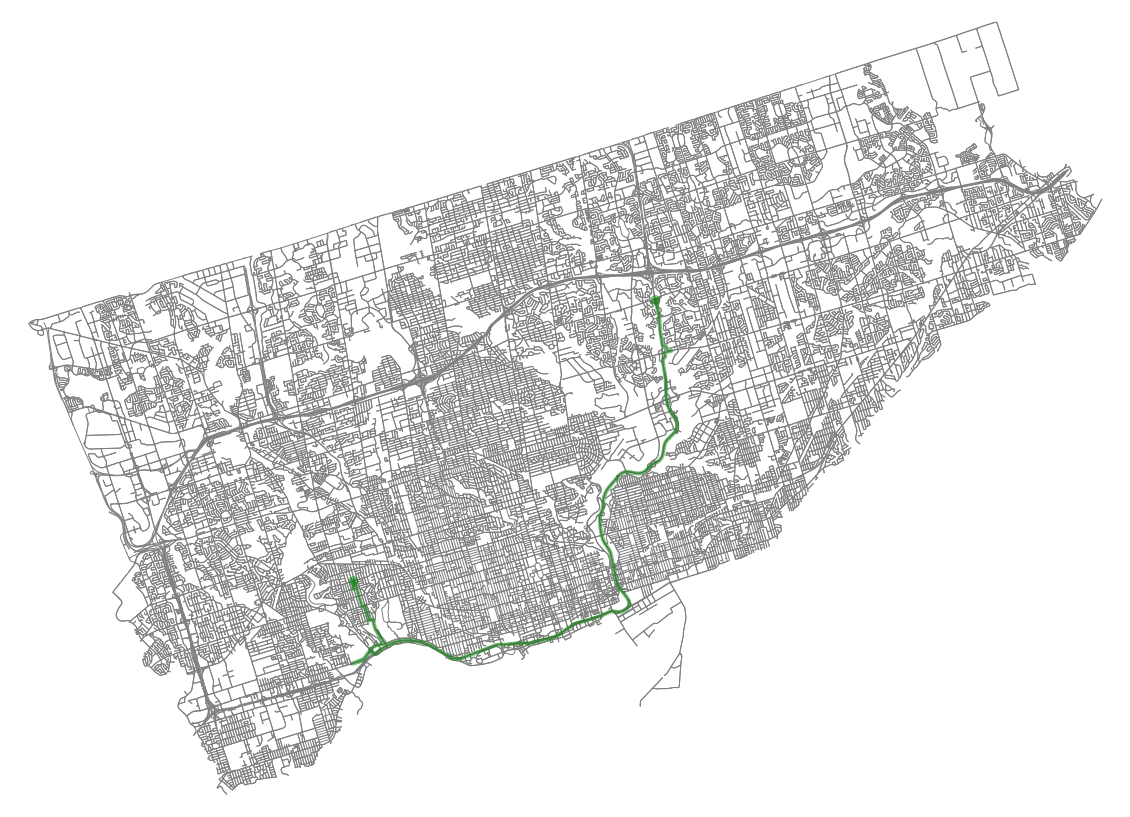

In [62]:
plot_route(route_risk, 'g')

## Clustering

In [50]:
def most_central_edge(net):
    centrality = nx.edge_betweenness_centrality(net, k = 25)
    return max(centrality, key=centrality.get)

In [87]:
gn = girvan_newman(G, most_valuable_edge=most_central_edge)
limited = itertools.takewhile(lambda c: len(c) <= 100, gn)

In [88]:
communities = None
for communities in limited:
    pass
community_tuple = tuple(c for c in communities)

In [104]:
cc1 = community_tuple[0]
cc2 = community_tuple[1]
cc3 = community_tuple[2]
cc4 = community_tuple[3]
cc5 = community_tuple[4]

In [105]:
print(len(cc1))
print(len(cc2))
print(len(cc3))
print(len(cc4))
print(len(cc5))

1220
1199
1509
1701
1659


## Printing Graphs

In [106]:
# nc = ['red' if node in cc else 'gray' for node in G.nodes()]
# ec = ['red' if (edge[0] in cc) or (edge[1] in cc) else 'gray' for edge in G.edges()]
ec = []
for edge in G.edges():
  if (edge[0] in cc1) or (edge[1] in cc1):
    ec.append('red')
  elif (edge[0] in cc2) or (edge[1] in cc2):
    ec.append('blue')
  elif (edge[0] in cc3) or (edge[1] in cc3):
    ec.append('green')
  elif (edge[0] in cc4) or (edge[1] in cc4):
    ec.append('orange')
  elif (edge[0] in cc5) or (edge[1] in cc5):
    ec.append('purple')
  else:
    ec.append("gray")

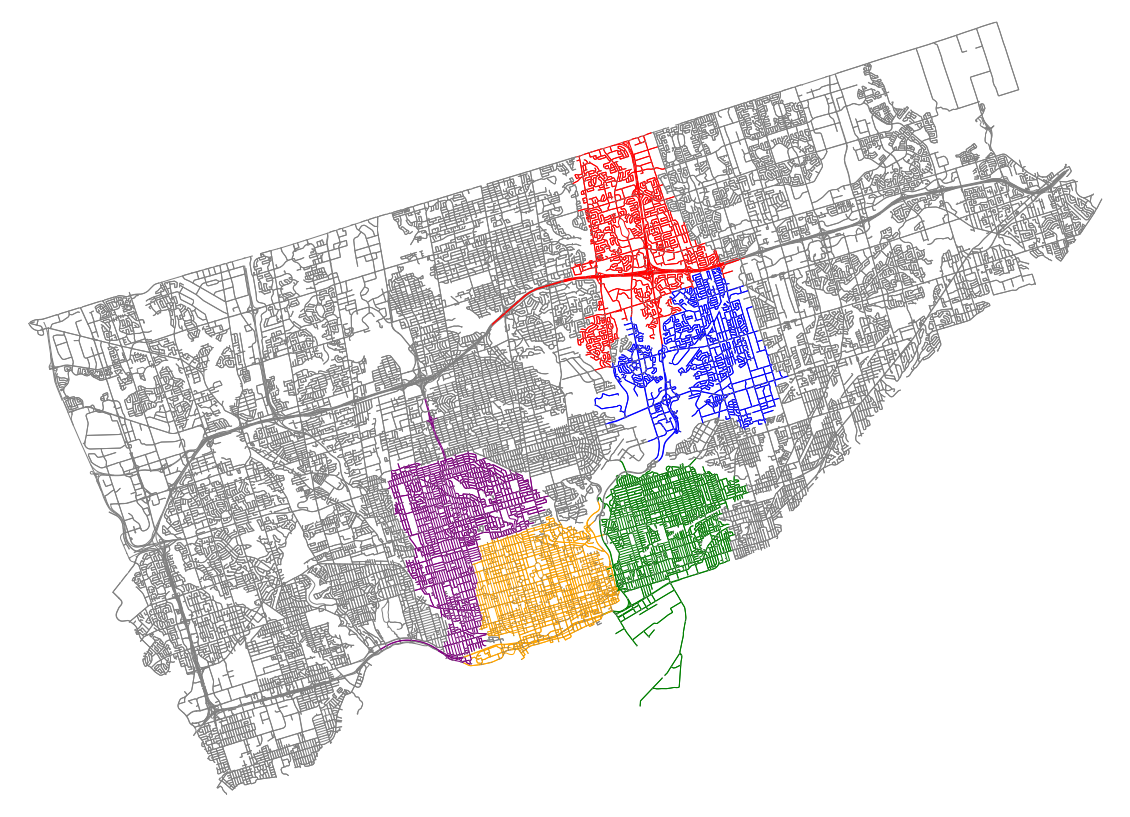

(<Figure size 1440x1440 with 1 Axes>, <AxesSubplot:>)

In [107]:
ox.plot_graph(G, bgcolor='white', node_size=1.0, node_color='gray', edge_color=ec, edge_linewidth=1.0, edge_alpha=1, dpi=300, figsize=(20,20))